In [1]:
#house price
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

train_y = train_data['SalePrice']

all_data = pd.concat([train_data.loc[:,'MSSubClass':'SaleCondition'], 
                      test_data.loc[:,'MSSubClass':'SaleCondition']])

print(train_data.shape)
print(test_data.shape)
print(all_data.shape)

# data_test[cols].isnull().sum()

(1460, 81)
(1459, 80)
(2919, 79)


+ **df.skew**  : 查看当前样本的偏差值
+ **np.log1p** : 将数据尽量处理成正态分布


1.8828757597682129


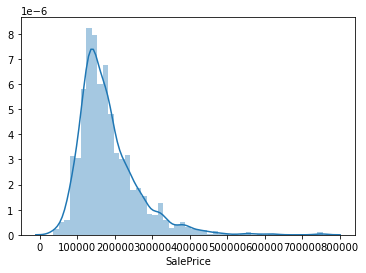

In [3]:

print(train_data['SalePrice'].skew())

sns.distplot(train_data['SalePrice'])


0.12134661989685333


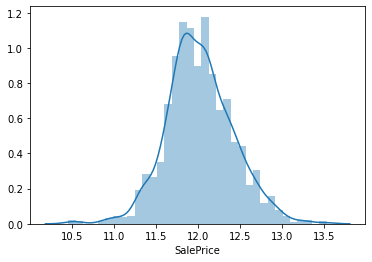

In [4]:
print(np.log1p(train_data['SalePrice']).skew())

sns.distplot(np.log1p(train_data['SalePrice']))

In [5]:
# 将数据中的其他列也进行正态化处理

train_y = np.log1p(train_y)

skew_col = all_data.dtypes[all_data.dtypes != 'object'].index
skew_col = all_data[skew_col].skew()
skew_col = skew_col[skew_col > 0.75].index

all_data[skew_col] = np.log1p(all_data[skew_col])

In [6]:
# 查看缺失值情况
nan_col = all_data.isnull().sum()
nan_col = nan_col[nan_col>0]
nan_col = nan_col.sort_values(ascending=False)

nan_col

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [7]:
# 缺失值过大直接删除
large_nan_col = nan_col[nan_col / all_data.shape[0] > 0.7].index

print(large_nan_col)

all_data.drop(large_nan_col, axis=1, inplace = True)
all_data.shape
# new_all_data.isnull().sum().sort_values(as)

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')


(2919, 75)

In [8]:
# 缺失值过小的直接用平均数或者众数填充
mini_nan_col = nan_col[nan_col / all_data.shape[0] < 0.1].index


new_all_data = all_data[mini_nan_col]

num_col = new_all_data.dtypes[new_all_data.dtypes != 'object'].index 
obj_col = new_all_data.dtypes[new_all_data.dtypes == 'object'].index 

all_data[num_col] = all_data[num_col].fillna(all_data[num_col].mean())
all_data[obj_col] = all_data[obj_col].fillna(all_data[obj_col].mode().iloc[0])

In [9]:

# 剩余两个单独处理
all_data['FireplaceQu'].fillna('None', inplace= True)
# 根据相同邻居进行中位数填充
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [ ]:
all_data = all_data.fillna(all_data.mean())

In [35]:
all_data = pd.get_dummies(all_data)

train_x = all_data[:train_y.shape[0]]
test_x = all_data[train_y.shape[0]:]


print(train_x.shape)
print(test_x.shape)
print(train_y.shape)


(1460, 276)
(1459, 276)
(1460,)


In [20]:
from sklearn import preprocessing
# 加正则化之后效果反而不好
# test_x = preprocessing.StandardScaler().fit_transform(train_x)
# test_y = preprocessing.StandardScaler().fit_transform(train_y.values.reshape(-1, 1))

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [48]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
models = [
    LinearRegression(),
    Ridge(), # 线性回归的基础上+L2正则
    Lasso(), # 线性回归的基础上+L1正则
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    LinearSVR(),
    ElasticNet(), # 弹性网络回归
    SGDRegressor(),
    BayesianRidge(), # 贝叶斯岭
    KernelRidge(), # KRR与SVR损失函数不同
    ExtraTreesRegressor(),
    XGBRegressor()
]

for name, model in zip(names, models):
    score = rmse_cv(model)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.138460, 0.0182
Ridge: 0.130342, 0.0166
Lasso: 0.268183, 0.0107
RF: 0.143216, 0.0100
GBR: 0.125074, 0.0095
SVR: 0.285969, 0.0111
LinSVR: 0.304239, 0.0599
Ela: 0.264383, 0.0109
SGD: 6930859599345962.000000, 2796963088907157.5000
Bay: 0.126988, 0.0158
Ker: 0.130446, 0.0167
Extra: 0.137819, 0.0166
Xgb: 0.138806, 0.0109


In [49]:
def grid_get(model,X, y,param_grid):
        grid_search = GridSearchCV(model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [51]:
# LinearRegression
lr_params = {
    'normalize' : [True,False]
}

grid_get(LinearRegression(), train_x,train_y, lr_params)

{'normalize': False} 0.13964720845536366
                 params  mean_test_score  std_test_score
0   {'normalize': True}     1.329137e+12    3.532957e+24
1  {'normalize': False}     1.396472e-01    4.943337e-03


In [64]:
# Ridge
ridge_params = {
    'alpha' : [0.3, 1, 3, 5, 10, 15, 50],
    'normalize' : [True,False],
    'max_iter' : [10, 50, 100, 500, 1000, 2000]
}
grid_get(Ridge(), train_x,train_y, ridge_params)


{'alpha': 10, 'max_iter': 10, 'normalize': False} 0.12753269787318966
                                               params  mean_test_score  \
0   {'alpha': 0.3, 'max_iter': 10, 'normalize': True}         0.131335   
1   {'alpha': 0.3, 'max_iter': 10, 'normalize': Fa...         0.134871   
2   {'alpha': 0.3, 'max_iter': 50, 'normalize': True}         0.131335   
3   {'alpha': 0.3, 'max_iter': 50, 'normalize': Fa...         0.134871   
4   {'alpha': 0.3, 'max_iter': 100, 'normalize': T...         0.131335   
..                                                ...              ...   
79  {'alpha': 50, 'max_iter': 500, 'normalize': Fa...         0.131426   
80  {'alpha': 50, 'max_iter': 1000, 'normalize': T...         0.320993   
81  {'alpha': 50, 'max_iter': 1000, 'normalize': F...         0.131426   
82  {'alpha': 50, 'max_iter': 2000, 'normalize': T...         0.320993   
83  {'alpha': 50, 'max_iter': 2000, 'normalize': F...         0.131426   

    std_test_score  
0         0.004144  

In [61]:
# Lasso
lasso_params = {
    'alpha' : [0.0001, 0.0005, 0.001, 0.003, 0.01],  
    'max_iter' : [200, 250, 300, 350]
}
grid_get(Lasso(), train_x,train_y, lasso_params)

{'alpha': 0.0005, 'max_iter': 250} 0.12321838684004136
                                params  mean_test_score  std_test_score
0   {'alpha': 0.0001, 'max_iter': 200}         0.129377        0.004563
1   {'alpha': 0.0001, 'max_iter': 250}         0.129374        0.004561
2   {'alpha': 0.0001, 'max_iter': 300}         0.129375        0.004561
3   {'alpha': 0.0001, 'max_iter': 350}         0.129375        0.004561
4   {'alpha': 0.0005, 'max_iter': 200}         0.123218        0.004090
5   {'alpha': 0.0005, 'max_iter': 250}         0.123218        0.004090
6   {'alpha': 0.0005, 'max_iter': 300}         0.123218        0.004090
7   {'alpha': 0.0005, 'max_iter': 350}         0.123218        0.004090
8    {'alpha': 0.001, 'max_iter': 200}         0.124868        0.004008
9    {'alpha': 0.001, 'max_iter': 250}         0.124868        0.004008
10   {'alpha': 0.001, 'max_iter': 300}         0.124868        0.004008
11   {'alpha': 0.001, 'max_iter': 350}         0.124868        0.004008
12   {'al

In [69]:
# BayesianRidge
bayes_params = {
    'alpha_1' : [0.0005, 0.001],  
    'alpha_2' : [0.1, 1.0, 3.0, 10],  
    'n_iter' : [10, 30, 50, 80]
}
grid_get(BayesianRidge(), train_x,train_y, bayes_params)




{'alpha_1': 0.001, 'alpha_2': 3.0, 'n_iter': 10} 0.12761852274607743
                                               params  mean_test_score  \
0   {'alpha_1': 0.0005, 'alpha_2': 0.1, 'n_iter': 10}         0.127975   
1   {'alpha_1': 0.0005, 'alpha_2': 0.1, 'n_iter': 30}         0.127918   
2   {'alpha_1': 0.0005, 'alpha_2': 0.1, 'n_iter': 50}         0.127918   
3   {'alpha_1': 0.0005, 'alpha_2': 0.1, 'n_iter': 80}         0.127918   
4   {'alpha_1': 0.0005, 'alpha_2': 1.0, 'n_iter': 10}         0.127644   
5   {'alpha_1': 0.0005, 'alpha_2': 1.0, 'n_iter': 30}         0.127630   
6   {'alpha_1': 0.0005, 'alpha_2': 1.0, 'n_iter': 50}         0.127630   
7   {'alpha_1': 0.0005, 'alpha_2': 1.0, 'n_iter': 80}         0.127630   
8   {'alpha_1': 0.0005, 'alpha_2': 3.0, 'n_iter': 10}         0.127619   
9   {'alpha_1': 0.0005, 'alpha_2': 3.0, 'n_iter': 30}         0.127625   
10  {'alpha_1': 0.0005, 'alpha_2': 3.0, 'n_iter': 50}         0.127625   
11  {'alpha_1': 0.0005, 'alpha_2': 3.0, 'n_

In [74]:
# GradientBoostingRegressor

gbr_params = {
    'n_estimators' : [100, 300, 500],  
    'loss' : ['ls','lad','huber'],  
    'learning_rate' : [0.1,0.3]
}
grid_get(GradientBoostingRegressor(), train_x,train_y,gbr_params)


{'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 500} 0.1219162427910376
                                               params  mean_test_score  \
0   {'learning_rate': 0.1, 'loss': 'ls', 'n_estima...         0.126022   
1   {'learning_rate': 0.1, 'loss': 'ls', 'n_estima...         0.123485   
2   {'learning_rate': 0.1, 'loss': 'ls', 'n_estima...         0.124241   
3   {'learning_rate': 0.1, 'loss': 'lad', 'n_estim...         0.136022   
4   {'learning_rate': 0.1, 'loss': 'lad', 'n_estim...         0.126519   
5   {'learning_rate': 0.1, 'loss': 'lad', 'n_estim...         0.126866   
6   {'learning_rate': 0.1, 'loss': 'huber', 'n_est...         0.127248   
7   {'learning_rate': 0.1, 'loss': 'huber', 'n_est...         0.122501   
8   {'learning_rate': 0.1, 'loss': 'huber', 'n_est...         0.121916   
9   {'learning_rate': 0.3, 'loss': 'ls', 'n_estima...         0.134530   
10  {'learning_rate': 0.3, 'loss': 'ls', 'n_estima...         0.136351   
11  {'learning_rate': 0.3, 'loss

In [75]:

# 'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 300}

gbr_model = GradientBoostingRegressor(n_estimators=500,loss='huber', learning_rate=0.1).fit(train_x, train_y)
rmse_cv(gbr_model).mean()

0.12267017058740308

In [39]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_x, train_y)

rmse_cv(model_lasso).mean()

0.12232611721448199

In [80]:
# import xgboost as xgb
# # xgboost
# xgb_params = {
#     'n_estimators' : [100, 300, 500, 1000],  
#     'max_depth' : [2,3,4],  
#     'learning_rate' : [0.1,0.3]
# }
# grid_get(xgb.XGBRegressor(), train_x,train_y,xgb_params)

model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
rmse_cv(model_xgb).mean()

0.12362127658139843

In [82]:
model_xgb.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data] * weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [108]:
# model_list = [
#     Ridge(alpha=10, max_iter=10), # 线性回归的基础上+L2正则
#     Lasso(alpha=0.005, max_iter=250), # 线性回归的基础上+L1正则
#     GradientBoostingRegressor(n_estimators=500,loss='huber', learning_rate=0.1),
#     BayesianRidge(alpha_1=0.001, alpha_2=3.0, n_iter = 10), # 贝叶斯岭
#     XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
# ]
# wight_list = [0.1, 0.4, 0.2, 0.1, 0.2]

model_list_2 = [
    XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1),
    LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
]

wight_list_2 = [0.3, 0.7]

In [109]:
# avg_model = AverageWeight(model_list, wight_list)
avg_model_2 = AverageWeight(model_list_2, wight_list_2)
# avg_model.fit(train_x, train_y)


rmse_cv(avg_model_2).mean()

0.11862093651748126

In [110]:
avg_model.fit(train_x, train_y)

AverageWeight(mod=[Lasso(alpha=0.005, max_iter=250),
                   XGBRegressor(base_score=None, booster=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, gamma=None, gpu_id=None,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=None, max_depth=2,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=None, num_parallel_tree=None,
                                random_state=None, reg_alpha=None,
                                reg_lambda=None, scale_pos_weight=None,
                                subsample=None, tree_method=None,
                                validate_parameters=None, verbosity=None)],
              weight=[0.7,

In [111]:
pred_y = np.expm1(avg_model.predict(test_x))


In [112]:
# print(test_x.shape)
# print(pred_y.shape)

test_data['SalePrice'] = pred_y
res = test_data[['Id', 'SalePrice']]
res.to_csv('./submit/submit4.csv', index=False)


In [ ]:
# 获取相关性矩阵
corrmat = train_data.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corrmat, square=True)

In [ ]:
k = 10

col = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 
cm = np.corrcoef(train_data[col].values.T)

plt.figure(figsize=(20,9))
sns.heatmap(cm ,annot= True, square= True, xticklabels= col.values, yticklabels= col.values)


In [ ]:
from sklearn import preprocessing
f_names = ['CentralAir', 'Neighborhood']
for x in f_names:
    label = preprocessing.LabelEncoder()
    train_data[x] = label.fit_transform(train_data[x])
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [ ]:
k  = 10 # 关系矩阵中将显示10个特征
# 获取10个特征的标签
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(20, 9))
# annot 是否在格子上显示数字
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [ ]:
# 获取数据
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
x = train_data[cols].values
y = train_data['SalePrice'].values

X_train = preprocessing.StandardScaler().fit_transform(x)
y_train = train_data['SalePrice']

# x_scaled = preprocessing.StandardScaler().fit_transform(x)
# y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))
# X_train,X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33, random_state=42)

In [ ]:
clfs = {
    'svm':svm.SVR(), 
    'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
    'BayesianRidge':linear_model.BayesianRidge()
}

param_grid_svr = {
    'kernel' : ['rbf','sigmod','linear'], 
}


param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8]
}

param_grid_br = {
    'n_iter': [300, 500],
}

svr = svm.SVR()
svr_grad = GridSearchCV(svr, param_grid_svr,n_jobs=25, cv=10, scoring = 'r2',verbose=1)
svr_grad.fit(X_train, y_train)
print(svr_grad.best_estimator_)
print(svr_grad.best_score_)
print('=======================================')


rf = RandomForestRegressor(n_estimators=400)
rf_grad = GridSearchCV(rf, param_grid_rf,n_jobs=25, cv=10, scoring = 'r2',verbose=1)
rf_grad.fit(X_train, y_train)
print(rf_grad.best_estimator_)
print(rf_grad.best_score_)
print('=======================================')

br = linear_model.BayesianRidge()
br_grad = GridSearchCV(br, param_grid_br,n_jobs=25, cv=10, scoring = 'r2',verbose=1)
br_grad.fit(X_train, y_train)
print(br_grad.best_estimator_)
print(br_grad.best_score_)
print('=======================================')

# rf_cls_grid = model_selection.GridSearchCV(rf_cls, param_grid, n_jobs=25, cv=10, scoring = 'roc_auc',verbose=1)
# rf_cls_grid.fit(train_data_x, train_data_y)

# for clf in clfs:
#     try:
#         clf_grad = GridSearchCV(clfs[clf], param_grids[clf],n_jobs=25, cv=10, scoring = 'neg_mean_squared_error',verbose=1)
#         clf_grad.fit(X_train, y_train)
#         # clfs[clf].fit(X_train, y_train)
#         # y_pred = clfs[clf].predict(X_test)
#         y_pred = clf_grad(X_test)
#         print(clf + " cost:" + str(np.sum(abs(y_pred-y_test))/len(y_pred)) )
#     except Exception as e:
#         print(clf + " Error:")
#         print(str(e))

In [ ]:
from xgboost import XGBRegressor


xgb_param_test = {
    'n_estimators': [300,600,900],
    'max_depth': [ 3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.1]
    # 'min_child_weight': [1, 3, 10],
    # 'max_delta_step': [0, 0.3, 1, 3],
    # 'subsample': [0.6, 0.8, 0.95],
    # 'colsample_bytree': [0.5,0.7, 0.9],
    # 'reg_alpha': [0, 0.5, 1],
    # 'reg_lambda': [0.2, 0.6, 1],
    # 'scale_pos_weight': [0.2, 0.6, 1]
}

xgbreg = XGBRegressor()
xgbreg_grad = GridSearchCV(xgbreg, xgb_param_test,n_jobs=25, scoring = 'r2',verbose=1)
xgbreg_grad.fit(X_train, y_train)
print(xgbreg_grad.best_estimator_)
print(xgbreg_grad.best_score_)
print('=======================================')

In [ ]:
data_test = pd.read_csv('./dataset/test.csv')
# data_test[cols].isnull().sum()
data_test['GarageCars'].fillna(data_test['GarageCars'].mean(), inplace=True)
data_test['TotalBsmtSF'].fillna(data_test['TotalBsmtSF'].mean(), inplace=True)
data_test[cols].isnull().sum()

In [ ]:
test_x = data_test[cols]
x_scaled = preprocessing.StandardScaler().fit_transform(test_x)

In [ ]:

y_te_pred = xgbreg_grad.predict(x_scaled)

print(y_te_pred.shape)
print(test_x.shape)


In [ ]:
data_test['SalePrice'] = y_te_pred
res = data_test[['Id', 'SalePrice']]
res.head(10)


In [ ]:
res.to_csv('./submit/baseline_submit4.csv', index=False)